In [5]:
import os
import cv2
from deepface import DeepFace
from deepface.commons import functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from time import time

# Local descriptors
from skimage.feature import hog, local_binary_pattern
from skimage import  exposure
from skimage import feature

# Classifiers
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Definición de funciones

lbphist Definido un número de celdas, calcula el histograma LBP de cada una, concatenando los histogramas resultantes


GetPredictions y GetPredictionsandProbs obtienen las etiquetas o probabulidades paar un conjunto de test. 

In [6]:
def lbphist(ncellsx, ncellsy, type):
    #Rejilla de histogramas
    pxpercellx = int(width/ncellsx)
    pxpercelly = int(height/ncellsy)

    # Rejillas de igual tamaño y centradas en la imagen de entrada
    ofx = int((width - int(pxpercellx)*ncellsx)/2)
    ofy = int((height - int(pxpercelly)*ncellsy)/2)
    #print('Offset')
    #print(ofx,ofy)

    Xlbp = []

    LBPu_hist = []
    for i in range(0,ncellsy):
        for j in range(0,ncellsx):
            # Extrae celda
            roi=gray[ofy+i*pxpercelly:ofy+(i+1)*pxpercelly,ofx+j*pxpercellx:ofx+(j+1)*pxpercellx]
            # Obtiene imagen LBO
            lbpimg = feature.local_binary_pattern(roi, 8, 1,method=type)
            
            #Obtiene histograma
            n_bins = int(lbpimg.max()) + 1            
            #feath, bins = np.histogram(lbpimg.ravel(), normed=True, bins=n_bins, range=(0,n_bins))
            feath, bins = np.histogram(lbpimg, normed=False, bins=n_bins, range=(0,n_bins))
            
            # Concatena con celdas previas
            LBPu_hist= np.concatenate([LBPu_hist , feath])
            
    return LBPu_hist

In [7]:
def GetPredictions(X_train, X_test, y_train, y_test, model, parameters):
    model_name = type(model).__name__
    print(f"{model_name} training...")
    t0 = time()
    
    # Grid searach across parameter range
    clf = GridSearchCV(model, parameters, cv=5)
    clf = clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(X_test)
   
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test

def GetPredictionsandProbs(X_train, X_test, y_train, y_test):
    
    print("SVM Normalization...")
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(X_train)
    test_X = scaler.transform(X_test)

    print("SVM training...")
    t0 = time()
    parameters = {'C': [1e3, 5e3],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],}
    # Grid search across parameter range
    clf = GridSearchCV(
        SVC(kernel='rbf', class_weight='balanced', probability=True), parameters, cv=5
    )
    clf = clf.fit(train_X, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(test_X)
    
    # train and test class probabilities
    ytrain_prob = clf.predict_proba(train_X)
    ytest_prob = clf.predict_proba(test_X)
    
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test, ytrain_prob, ytest_prob

In [8]:
def calc_embs(model, X, batch_size=2):
    norm_images = prewhiten(X)
    pd = []
    for start in range(0, len(norm_images), batch_size):
        pd.append(model.predict_on_batch(norm_images[start:start+batch_size]))
    return l2_normalize(np.concatenate(pd))

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

In [3]:
!mkdir roi_dataset
!mkdir "roi_dataset/real"
!mkdir "roi_dataset/fake"

# Obtención de ROI (Cara)

Se realiza una clasificación de caras con OpenCV para reducir la cantidad de información usada en la clasificación de caras reales/falsas

In [25]:
# Localización de los datos
folder = "Database_real_and_fake_face_160x160"
dest_folder = "roi_dataset"
cascade_path = "haarcascade_frontalface_default.xml"

# Contador de número de clases del conjunto
nclasses = 0
# Contador de muestras por clase
nperclass = []
# Etiqueta de cada clase (nombre de la subcarpeta)
classlabels = []

n_images = 0

# Asume que en la ruta indicada hay una subcarpeta por clase
for class_name in os.listdir(folder):
    # Cada subcarpeta implica una clase más
    nclasses += 1
    # Inicialmente esta clase no tiene muestras
    nsamples = 0    

    # Compone la ruta
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Asume imágenes en formato jpg
        if file_name.endswith('.jpg'):
            # Lee la imagen
            image = cv2.imread (os.path.join(class_folder, file_name))
            
            # Extracción de la cara como ROI
            faceCascade = cv2.CascadeClassifier(cascade_path)
            faces = faceCascade.detectMultiScale(
                image,
                scaleFactor=1.3,
                minNeighbors=5,
                minSize=(30, 30)
            )

            if len(faces) > 0:
                for x, y, w, h in faces:
                    image = image[y:y + h, x:x + w]
                    cv2.imwrite(os.path.join(dest_folder, os.path.join(class_name,str(n_images) + '_faces.jpg')), image)
                    n_images += 1
            else:
                cv2.imwrite(os.path.join(dest_folder, os.path.join(class_name,str(n_images) + '_faces.jpg')), image)
                n_images += 1


# Carga conjunto de datos

Se proporciona la carpeta, a través de la variable folder, donde cada subcarpeta se corresponde con una clase.
Cada clase contiene muestras en forma de imágenes jpg, todas del mismo tamaño

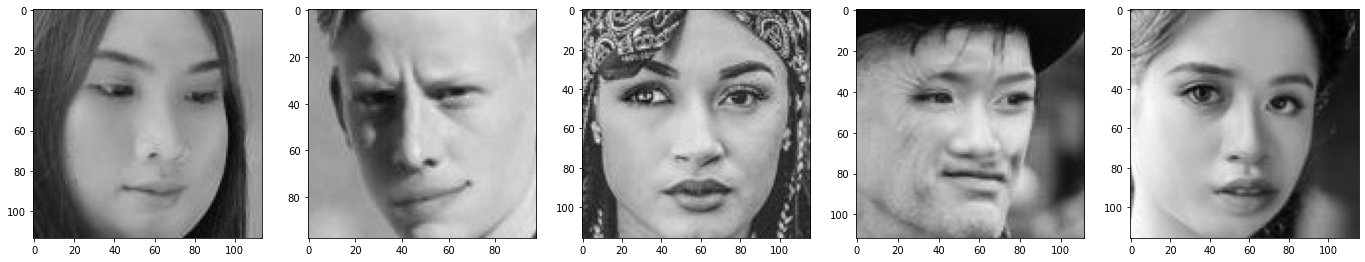

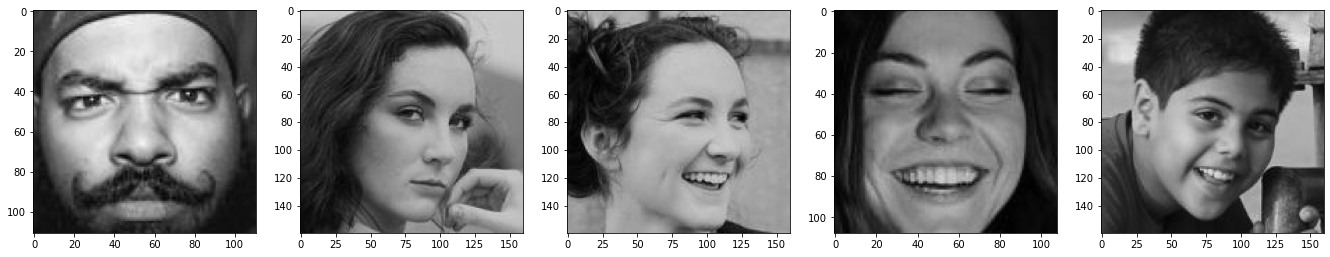

Features
(2041, 128)
(2041, 2622)
(2041,)


In [31]:
# Deepface
# Modelos disponibles ['VGG-Face', 'Facenet', 'OpenFace', 'DeepFace', 'DeepID', 'Dlib']
model_deepface = DeepFace.build_model("Facenet")
model_vggface = DeepFace.build_model("VGG-Face")

target_size = model_deepface.layers[0].input_shape[0]
dim = (int(target_size[1]), int(target_size[2]))

target_size_vgg = model_vggface.layers[0].input_shape[0]
dim_vgg = (int(target_size_vgg[1]), int(target_size_vgg[2]))

# Localización de los datos
folder = "roi_dataset"

# Contador de número de clases del conjunto
nclasses = 0
# Contador de muestras por clase
nperclass = []
# Etiqueta de cada clase (nombre de la subcarpeta)
classlabels = []
# Inicializa estructuras de datos y sus correpondientes etiquetas
X = []
Y = []
XFaceNet = []
XVGG = []

# Valor de resolución por defecto de matplotlib
dpi = matplotlib.rcParams['figure.dpi']
# Imágenes de muestra de cada clase a mostrar
nims2show = 5

# Asume que en la ruta indicada hay una subcarpeta por clase
for class_name in os.listdir(folder):
    # Cada subcarpeta implica una clase más
    nclasses += 1
    # Inicialmente esta clase no tiene muestras
    nsamples = 0    

    # Compone la ruta
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Asume imágenes en formato jpg
        if file_name.endswith('.jpg'):
            # Lee la imagen
            image = cv2.imread (os.path.join(class_folder, file_name))
            
            # Extrae tamaños
            height, width, depth = image.shape
            # Convierte  grises
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            X.append(gray.reshape(height*width))
            
            # Deepface con FaceNet
            # Obtiene embeddings
            img_embedding = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
            img_embedding = calc_embs(model_deepface, np.array([img_embedding]))
            XFaceNet.append(img_embedding[0])
            
            # Deepface con VGG-Face
            # Obtiene embeddings
            img_embedding = cv2.resize(image, dim_vgg, interpolation = cv2.INTER_AREA)
            img_embedding = calc_embs(model_vggface, np.array([img_embedding]))
            XVGG.append(img_embedding[0])
                    
            # Añade etiqueta numérica de la muestra
            Y.append(nclasses-1)
            
            # Muestra las nims2show primeras muestras de cada clase
            if nsamples < nims2show:
                if nsamples == 0:                    
                    figsize = 15*width / float(dpi), 15*height / float(dpi)
                    fig = plt.figure(figsize=figsize)                
                
                fig.add_subplot(1,nims2show, nsamples + 1)
                plt.imshow(gray, cmap='gray', vmin=0, vmax=255)                
                
            #Incrementa el número de muestras
            nsamples += 1
    plt.show()
    nperclass.append(nsamples)
    classlabels.append(class_name)
    
#Convierte a numpy array X e Y
Y = np.array(Y,dtype='float64')
XFaceNet = np.array(XFaceNet,dtype='float32')
XVGG = np.array(XVGG,dtype='float32')

# Muestra datos del conjunto leído
# Depuración
print("Features")
print(XFaceNet.shape)
print(XVGG.shape)
print(Y.shape)
# Obtiene número de muestras y características
# Obtiene nombres de las clases
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

# Diseña conjunto experimental k-fold

Divide los datos k veces en conjunto de entrenamiento y test

In [32]:
# StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=7, shuffle=True)

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    fold += 1

Fold 1
# samples in training set 1632
# samples in test set 409
Fold 2
# samples in training set 1633
# samples in test set 408
Fold 3
# samples in training set 1633
# samples in test set 408
Fold 4
# samples in training set 1633
# samples in test set 408
Fold 5
# samples in training set 1633
# samples in test set 408


# Para cada fold

Obtiene resultados con HOG y LBP. Además entrena un clasificador basado por fusión de scores (score level fusion) de los obtenidos de los clasificadores previos.

In [34]:
print("+++++++++++++++++++++++++++++++++++++++++++\n")

# KNN 
precs_vgg_svm, recs_vgg_svm, acc_vgg_svm = [], [], []
precs_facenet_svm, recs_facenet_svm, acc_facenet_svm = [], [], []

precs_vgg_rf, recs_vgg_rf, acc_vgg_rf = [], [], []
precs_facenet_rf, recs_facenet_rf, acc_facenet_rf = [], [], []


SVM = SVC(kernel='rbf', class_weight='balanced')
SVM_parameters = {
    'C': [1e3, 5e3],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],
}

RF = RandomForestClassifier()
RF_parameters = {
    'n_estimators': [100, 150, 200],
}

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("*********************\nFold %d" % fold)
        
    #Facenet
    print("\nDeepface/Facenet")
    y_pred, y_test = GetPredictions(XFaceNet[train_index], XFaceNet[test_index],Y[train_index], Y[test_index], SVM, SVM_parameters)
    print("\nDeepface/Facenet + SVM Metrics")
    precs_facenet_svm.append(precision_score(y_test, y_pred))
    recs_facenet_svm.append(recall_score(y_test, y_pred))
    acc_facenet_svm.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))
    if fold == 1:
        print("Confussion matrix:")
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
        
    y_pred, y_test = GetPredictions(XFaceNet[train_index], XFaceNet[test_index],Y[train_index], Y[test_index], RF, RF_parameters)
    print("\nDeepface/Facenet + RF Metrics")
    precs_facenet_rf.append(precision_score(y_test, y_pred))
    recs_facenet_rf.append(recall_score(y_test, y_pred))
    acc_facenet_rf.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))
    if fold == 1:
        print("Confussion matrix:")
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes))) 
        
    #VGG-Face
    print("\nVGG-Face/Facenet")
    y_pred, y_test = GetPredictions(XVGG[train_index], XVGG[test_index],Y[train_index], Y[test_index], SVM, SVM_parameters)
    print("\nDeepface/Facenet + SVM Metrics")
    precs_vgg_svm.append(precision_score(y_test, y_pred))
    recs_vgg_svm.append(recall_score(y_test, y_pred))
    acc_vgg_svm.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))
    if fold == 1:
        print("Confussion matrix:")
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
        
    y_pred, y_test = GetPredictions(XVGG[train_index], XVGG[test_index],Y[train_index], Y[test_index], RF, RF_parameters)
    print("\nVGG-Face/Facenet + RF Metrics")
    precs_vgg_rf.append(precision_score(y_test, y_pred))
    recs_vgg_rf.append(recall_score(y_test, y_pred))
    acc_vgg_rf.append(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=class_names))
    if fold == 1:
        print("Confussion matrix:")
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes))) 
        
        
    fold += 1



   

+++++++++++++++++++++++++++++++++++++++++++

*********************
Fold 1

Deepface/Facenet
SVC training...
done in 13.223s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.005)
Predicting
done in 0.076s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.51      0.56      0.54       192
        real       0.58      0.53      0.55       217

    accuracy                           0.54       409
   macro avg       0.54      0.54      0.54       409
weighted avg       0.55      0.54      0.54       409

Confussion matrix:
[[108  84]
 [103 114]]
RandomForestClassifier training...
done in 21.789s
Best estimator found by grid search:
RandomForestClassifier()
Predicting
done in 0.016s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.50      0.39      0.44       192
        real       0.55      0.66      0.60       217

    accuracy              

done in 13.640s
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=0.001)
Predicting
done in 0.078s

Deepface/Facenet + SVM Metrics
              precision    recall  f1-score   support

        fake       0.51      0.53      0.52       192
        real       0.57      0.55      0.56       216

    accuracy                           0.54       408
   macro avg       0.54      0.54      0.54       408
weighted avg       0.54      0.54      0.54       408

RandomForestClassifier training...
done in 24.498s
Best estimator found by grid search:
RandomForestClassifier(n_estimators=200)
Predicting
done in 0.032s

Deepface/Facenet + RF Metrics
              precision    recall  f1-score   support

        fake       0.49      0.42      0.45       192
        real       0.54      0.62      0.58       216

    accuracy                           0.52       408
   macro avg       0.52      0.52      0.52       408
weighted avg       0.52      0.52      0.52       40

In [35]:
print("\n********K-FOLD SUMMARY*********")
print("Facenet+SVM Mean Precision:  %0.3f, Mean Recall:  %0.3f, Mean Accuracy:  %0.3f" % ( np.mean(precs_facenet_svm) , np.mean(recs_facenet_svm) , np.mean(acc_facenet_svm) ))
print("Facenet+RF Mean Precision:  %0.3f, Mean Recall:  %0.3f, Mean Accuracy:  %0.3f" % ( np.mean(precs_facenet_rf) , np.mean(recs_facenet_rf) , np.mean(acc_facenet_rf) ))
print("VGG-Face+SVM Mean Precision:  %0.3f, Mean Recall:  %0.3f, Mean Accuracy:  %0.3f" % ( np.mean(precs_vgg_svm) , np.mean(recs_vgg_svm) , np.mean(acc_vgg_svm) ))
print("VGG-Face+RF Mean Precision:  %0.3f, Mean Recall:  %0.3f, Mean Accuracy:  %0.3f" % ( np.mean(precs_vgg_rf) , np.mean(recs_vgg_rf) , np.mean(acc_vgg_rf) ))


********K-FOLD SUMMARY*********
Facenet+SVM Mean Precision:  0.579, Mean Recall:  0.561, Mean Accuracy:  0.551
Facenet+RF Mean Precision:  0.559, Mean Recall:  0.667, Mean Accuracy:  0.545
VGG-Face+SVM Mean Precision:  0.619, Mean Recall:  0.587, Mean Accuracy:  0.589
VGG-Face+RF Mean Precision:  0.590, Mean Recall:  0.682, Mean Accuracy:  0.580
